# Model Training using Lifetimes

### Importing all the necessary libraries, modules and reading the file into a dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.datasets import load_transaction_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix , ConfusionMatrixDisplay, precision_score, recall_score
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('MODEL_TRAINING.csv')
df.head()

,Unnamed: 0,ID,DEVICE_ID,POST_RELEASE_PURCHASE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BAND_1800,BAND_1900,...,OS_CODE,BATTERY_TYPE_CODE,MULTISIM_MODE_CODE,BRAND_CODE,MODEL_CODE,NETTYPE_CODE,START_DATE,END_DATE,RELEASE_DATE,IS_CHANGED
0,4978529,1,1343900,1293,456,551.2,1,0,1,1,...,0.211316,1,2,0.211316,0.010954,3,2016-03-01,2017-05-31,2012-08-16,1
1,8167674,1,35579407,457,882,642.5,1,0,1,1,...,0.211316,0,2,0.211316,0.004705,4,2017-06-01,2019-10-31,2016-03-01,1
2,4643647,2,86545602,1127,910,531.1,0,0,1,1,...,0.741953,0,2,0.040123,0.001340,3,2017-01-01,2019-06-30,2013-12-01,1
3,10284868,2,35152604,2491,637,403.3,0,0,1,1,...,0.022345,0,2,0.040552,0.000028,3,2017-02-01,2018-10-31,2010-04-08,1
4,11168153,2,35930004,2618,89,444.1,0,0,1,1,...,0.010124,0,2,0.040552,0.000361,3,2018-12-01,2019-02-28,2011-10-01,1


#### Taking a more compact version of the initial dataframe

In [3]:
final_df = df[[ 'ID', 'DEVICE_ID', 'POST_RELEASE_PURCHASE', 'DAYS_USED',
       'AVG_DAYS_USED', 'RELEASE_YEAR',  'BRAND_CODE', 'MODEL_CODE',
       'START_DATE', 'END_DATE', 'RELEASE_DATE']]

In [4]:
final_df = final_df[final_df['START_DATE'] >= '2014-1-1']

In [5]:
final_df = final_df.groupby('ID').filter(lambda x: len(x) > 1)
final_df = final_df.groupby('ID').filter(lambda x: len(x) <= 25)

## 1st Model

In [6]:
summary = summary_data_from_transaction_data(final_df, 'ID', 'END_DATE', 
                observation_period_end=final_df['END_DATE'].max())

bgf = BetaGeoFitter(penalizer_coef= 0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(150, 
    summary['frequency'], summary['recency'], summary['T'])
summary

,frequency,recency,T,predicted_purchases
ID,,,,
1,1.0,883.0,2599.0,0.133609
2,9.0,2081.0,2081.0,0.478248
5,2.0,408.0,408.0,0.353907
6,2.0,3147.0,3147.0,0.149778
7,3.0,2354.0,2354.0,0.217724
...,...,...,...,...
6400125,1.0,2691.0,2691.0,0.130745
6400148,1.0,2630.0,2630.0,0.132630
6400164,1.0,1930.0,1930.0,0.158918


## Testing how our model performs on data not yet seen.

In [7]:
summary_cal_holdout = calibration_and_holdout_data(final_df, 'ID', 'END_DATE',
                                        calibration_period_end='2024-2-13',
                                        observation_period_end='2024-7-12' ) #for 5months |for 3months 2024-4-13(calib_per_end)
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
ID,,,,,
1,1.0,883.0,2449.0,0.0,150.0
2,8.0,1887.0,1931.0,1.0,150.0
5,1.0,61.0,258.0,1.0,150.0
6,1.0,2466.0,2997.0,1.0,150.0
7,2.0,1885.0,2204.0,1.0,150.0


#### With this dataset, we can perform fitting on the _cal columns, and test on the _holdout columns:

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

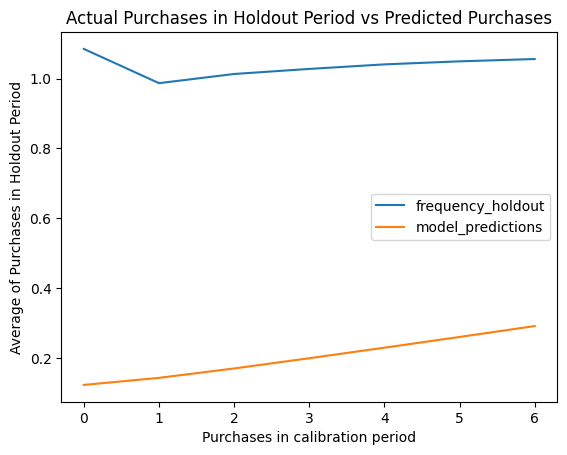

In [8]:
bgf.fit(summary_cal_holdout['frequency_cal'],
         summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

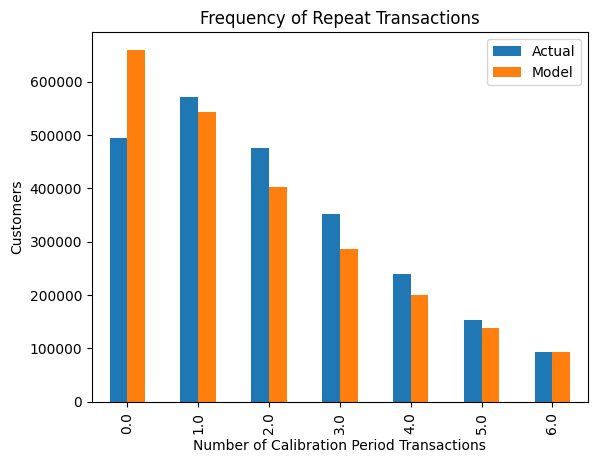

In [9]:
plot_period_transactions(bgf)

## Customer Predictions

## Based on customer history, we can predict what an individuals future purchases might look like:

In [10]:
t = 120 
individual = summary.iloc[20]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.14825183703702724

##### Custom function designed for training the model. 

##### Function receives the dataframe and the quantity of days we want to make predictions

In [11]:
def predict_purchases(dataframe : pd.DataFrame, days: int, coef: float = 0.0) -> pd.DataFrame:
    """
     Predicts customer purchases based on transaction data using the BG/NBD model from the lifetimes library.

    Parameters:
    dataframe (pd.DataFrame): A DataFrame containing transaction data with columns 'ID' and 'END_DATE'.
    days (int): The number of days into the future for which to predict purchases.
    coef (float, optional): Penalizer coefficient for the BG/NBD model to control for overfitting. Default is 0.0.

    Returns:
    pd.DataFrame: A summary DataFrame with predicted purchases for each customer.
                  The DataFrame includes the following columns:
                  - 'frequency': Number of repeat purchases.
                  - 'recency': Time between first purchase and the end of the observation period.
                  - 'T': Time between the first purchase and the end of the observation period.
                  - 'predicted_purchases': Expected number of purchases in the specified future period.
    """
    summary = summary_data_from_transaction_data(dataframe, 'ID', 'END_DATE', observation_period_end=df['END_DATE'].max())

    bgf = BetaGeoFitter(penalizer_coef= coef)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])

    summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(days, summary['frequency'], summary['recency'], summary['T'])
    return summary

##### A function employed for filtering the predictions above the given ratio

In [12]:
def filter_predictions_by_ratio_above(summary : pd.DataFrame, ratio : float) -> pd.DataFrame:
    """
    Filters the predictions to include only those with predicted purchases above a given ratio.

    Parameters:
    summary (pd.DataFrame): A DataFrame containing customer purchase predictions with a 'predicted_purchases' column.
    ratio (float): The threshold ratio above which to filter the predicted purchases.

    Returns:
    pd.DataFrame: A DataFrame filtered to include only rows where 'predicted_purchases' is greater than the specified ratio.
                  If the ratio is not a float, an error message is printed and an empty DataFrame is returned.
    """
    if isinstance(ratio, float):
        result = summary[summary['predicted_purchases']  > ratio]
        return result
    else:
        print("The provided ratio must be float")

##### A function employed for filtering the predictions below the given ratio

In [13]:
def filter_predictions_by_ratio_below(summary : pd.DataFrame, ratio : float) -> pd.DataFrame:
    """
    Filters the predictions to include only those with predicted purchases below a given ratio.

    Parameters:
    summary (pd.DataFrame): A DataFrame containing customer purchase predictions with a 'predicted_purchases' column.
    ratio (float): The threshold ratio below which to filter the predicted purchases.

    Returns:
    pd.DataFrame: A DataFrame filtered to include only rows where 'predicted_purchases' is lower than the specified ratio.
                  If the ratio is not a float, an error message is printed and an empty DataFrame is returned.
    """
    if isinstance(ratio, float):
        result = summary[summary['predicted_purchases'] < ratio]
        return result
    else:
        print("The provided ratio must be float")

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

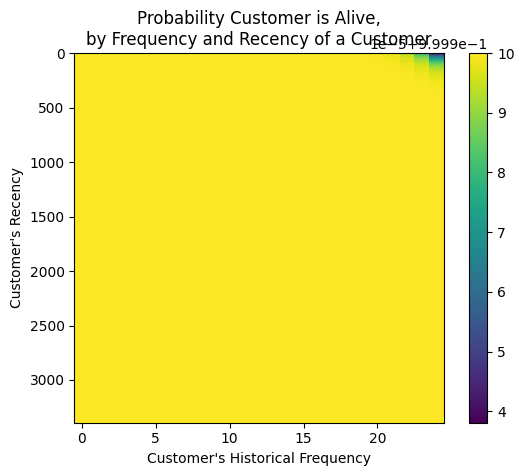

In [14]:
plot_probability_alive_matrix(bgf)


# Model assessment

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

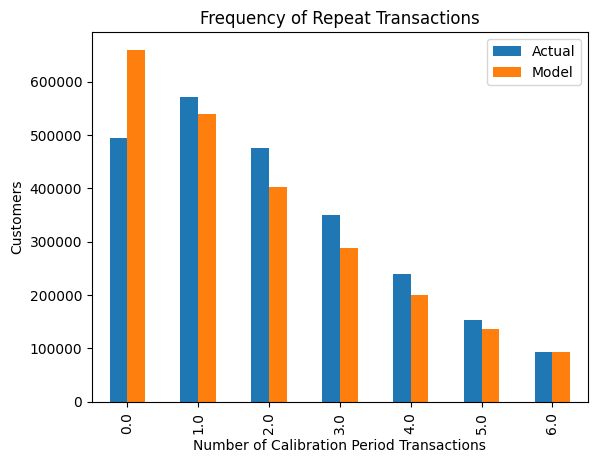

In [15]:
plot_period_transactions(bgf)

## 2nd for comparing

In [16]:
start_period = '2024-02-13'
end_period = '2024-07-12'

df_filtered = final_df[(final_df['END_DATE'] >= start_period) & (final_df['END_DATE'] <= end_period)]

changed_users = df_filtered['ID'].value_counts()
changed_users_set = set(changed_users[changed_users > 1].index)

final_df['PHONE_CHANGED'] = final_df['ID'].apply(lambda x: 1 if x in changed_users_set else 0)
df_result = final_df[['ID', 'DEVICE_ID', 'PHONE_CHANGED']]

In [17]:
df_result['PHONE_CHANGED'].value_counts()

PHONE_CHANGED
0    9711566
1    1412058
Name: count, dtype: int64

In [18]:
# Create the final DataFrame with '1' or '0' based on the PHONE_CHANGED column
user_change_status = df_result.groupby('ID')['PHONE_CHANGED'].max().reset_index()
user_change_status['CHANGED_PHONE'] = user_change_status['PHONE_CHANGED'].apply(lambda x: 1 if x == 1 else 0)
user_change_status = user_change_status[['ID', 'CHANGED_PHONE']]

user_change_status['CHANGED_PHONE'].value_counts()

CHANGED_PHONE
0    2277275
1     257588
Name: count, dtype: int64

In [19]:
summary

,frequency,recency,T,predicted_purchases
ID,,,,
1,1.0,883.0,2599.0,0.133609
2,9.0,2081.0,2081.0,0.478248
5,2.0,408.0,408.0,0.353907
6,2.0,3147.0,3147.0,0.149778
7,3.0,2354.0,2354.0,0.217724
...,...,...,...,...
6400125,1.0,2691.0,2691.0,0.130745
6400148,1.0,2630.0,2630.0,0.132630
6400164,1.0,1930.0,1930.0,0.158918


## Merging predicted data and actual output

In [20]:
merged_df = pd.merge(summary, user_change_status, on='ID', how='left')

In [21]:
merged_df.head(10)

,ID,frequency,recency,T,predicted_purchases,CHANGED_PHONE
0,1,1.0,883.0,2599.0,0.133609,0
1,2,9.0,2081.0,2081.0,0.478248,0
2,5,2.0,408.0,408.0,0.353907,0
3,6,2.0,3147.0,3147.0,0.149778,0
4,7,3.0,2354.0,2354.0,0.217724,0
5,8,11.0,2964.0,2964.0,0.451463,1
6,13,5.0,893.0,893.0,0.465485,1
7,14,3.0,2781.0,2781.0,0.196511,1
8,19,2.0,1442.0,1442.0,0.233679,0
9,20,2.0,1411.0,1411.0,0.236084,0


In [22]:
merged_df['threshold'] = (merged_df['predicted_purchases'] > 0.368).astype(int) #0.37

In [23]:
merged_df['threshold'].value_counts()

threshold
0    2335962
1     198901
Name: count, dtype: int64

## Metrics are employed to assess the model

In [24]:
f1 = f1_score(merged_df['CHANGED_PHONE'], merged_df['threshold'])
f1 = f"{f1:.2f}"
print(f'F1 Score: {f1}')


F1 Score: 0.24


In [25]:
accuracy = accuracy_score(merged_df['CHANGED_PHONE'], merged_df['threshold'])
accuracy = f"{accuracy:.2f}"
print(f'Accuracy: {accuracy}')

Accuracy: 0.86


In [26]:
recall = recall_score(merged_df['CHANGED_PHONE'], merged_df['threshold'])
recall = f"{recall:.2f}"
print(f'Recall: {recall}')

Recall: 0.21


In [27]:
precision = precision_score(merged_df['CHANGED_PHONE'], merged_df['threshold'])
precision = f"{precision:.2f}"
print(f'Precision: {precision}')

Precision: 0.28


## Definition: A matrix that shows the true positives, true negatives, false positives, and false negatives.

In [28]:
conf_matrix = confusion_matrix(merged_df['CHANGED_PHONE'], merged_df['threshold'])
print(f'Confusion Matrix:\n{conf_matrix}')

Confusion Matrix:
[[2133539  143736]
 [ 202423   55165]]


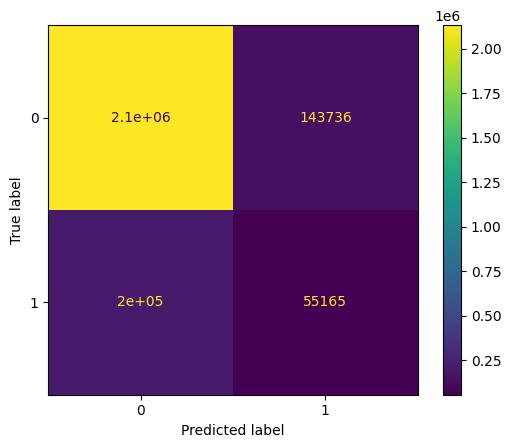

In [29]:
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])

cm_display.plot()
plt.show()

In [30]:
merged_df['ratio'] = merged_df['recency'] / merged_df['frequency']

recency_bins = [0, 300, 600, 900,  1200, 1800, 2400, 3000, 3600]
frequency_bins = [0, 1, 2, 3, 4, 5, 6, 7 ,8 , 10, 12, 15, 20, 25]
ratio_freqrec_bins = [25, 400, 800, 1200, 1700, 2200, 2800, 3600]

merged_df['recency_score'] = pd.cut(merged_df['recency'], bins=recency_bins, labels=False) + 1
merged_df['frequency_score'] = pd.cut(merged_df['frequency'], bins=frequency_bins, labels=False) + 1
merged_df['ratio_score'] = pd.cut(merged_df['ratio'], bins=ratio_freqrec_bins, labels=False) + 1

# merged_df['RFM_Score'] = merged_df['recency_score'].astype(str) + merged_df['frequency_score'].astype(str)
# merged_df['RFM_Score'] = merged_df['RFM_Score'].astype(int)

merged_df['RFM_INT'] = (merged_df['frequency_score'].astype(int)*2.78 - merged_df['recency_score'].astype(int)*(-1.038050)) + 3
merged_df['RFM_INT'] = merged_df['RFM_INT'].astype(int)

In [31]:
result = merged_df.groupby('RFM_INT')['ID'].nunique().reset_index()
result['RFM_INT'] = result['RFM_INT'].astype(int)

result.columns = ['RFM_INT', 'COUNT']

In [32]:
result

,RFM_INT,COUNT
0,6,86585
1,7,99118
2,8,74249
3,9,79487
4,10,129097
5,11,47736
6,12,124691
7,13,156515
8,14,187949
9,15,124561


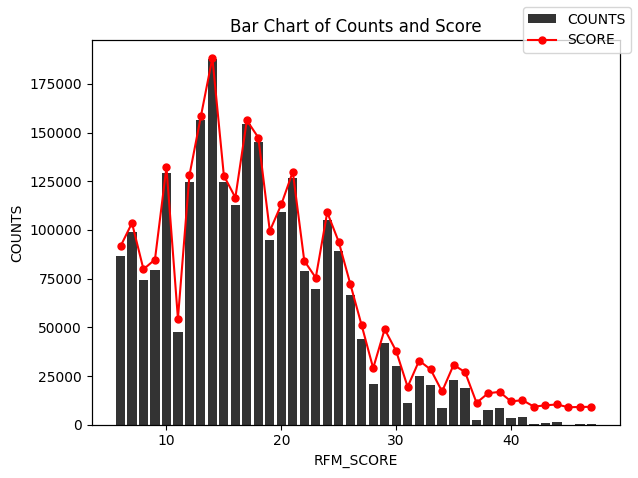

In [33]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('RFM_SCORE')
ax1.set_ylabel('COUNTS', color='black')
ax1.bar(result['RFM_INT'], result['COUNT'], color='black', alpha=0.8, label='COUNTS')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.plot(result['RFM_INT'], result['COUNT'], color='red', marker='o', markersize=5, label='SCORE')
ax2.yaxis.set_visible(False)

plt.title('Bar Chart of Counts and Score')
fig.tight_layout()
fig.legend(loc='upper right')

plt.show()

In [34]:
X = merged_df[['recency', 'frequency']]
y = merged_df['RFM_INT']

In [35]:
model = LinearRegression()
model.fit(X, y)

coefficients = model.coef_
intercept = model.intercept_

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


Coefficients: [2.38104885e-03 2.56485088e+00]
Intercept: 4.136294624684091


## Device changes per Seasons & Months

In [36]:
filtered_df = df[df['START_DATE'] < '2024-01-01']
filtered_df['START_DATE'] = pd.to_datetime(filtered_df['START_DATE'])
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

filtered_df['Season'] = filtered_df['START_DATE'].apply(get_season)

filtered_df['Season'] = filtered_df['START_DATE'].apply(get_season)


In [37]:
filtered_df['INDEX'] = range(1, len(filtered_df) + 1)

In [39]:
def get_month_name(date):
    return date.strftime('%B')

filtered_df['Month'] = filtered_df['START_DATE'].apply(get_month_name)

monthly_purchases = filtered_df.groupby('Month').agg({
    'INDEX': 'count'
}).rename(columns={'INDEX': 'PURCHASES'})

In [40]:
seasonal_purchases = filtered_df.groupby('Season').agg({
    'INDEX' : 'count'  
}).rename(columns={'INDEX': 'PURCHASES'})

#### Purchases by seasons


In [41]:
seasonal_purchases = seasonal_purchases.sort_values('PURCHASES', ascending=False)
seasonal_purchases

,PURCHASES
Season,
Fall,3290661
Summer,3126446
Winter,2920881
Spring,2532815


#### Purchases by months

In [42]:
monthly_purchases = monthly_purchases.sort_values('PURCHASES', ascending=False)
monthly_purchases

,PURCHASES
Month,
December,1274362
September,1194988
August,1108387
July,1099688
October,1053194
November,1042479
June,918371
January,900542
April,858109


## Number of Purchases by Season

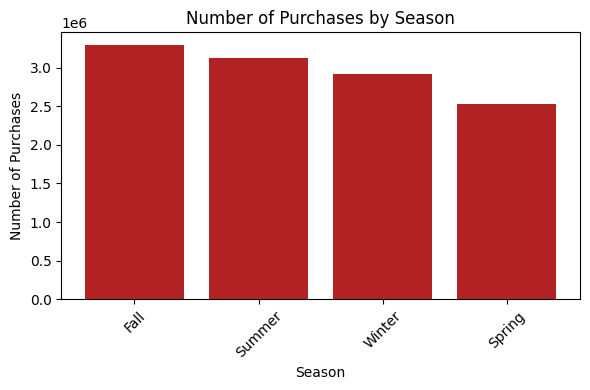

In [43]:
plt.figure(figsize=(6, 4))
plt.bar(seasonal_purchases.index, seasonal_purchases['PURCHASES'], 
        color='#B22222')
plt.xlabel('Season')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases by Season')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

## Number of Purchases by Month

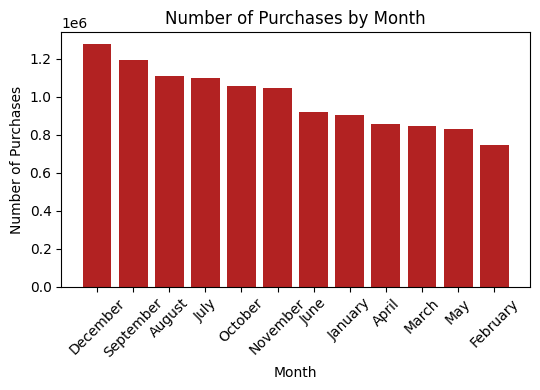

In [44]:
plt.figure(figsize=(5.5, 4))
plt.bar(monthly_purchases.index, monthly_purchases['PURCHASES'],
         color='#B22222')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases by Month')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

# Customer Segmentation

In [45]:
merged_df['recency'] = merged_df['recency'].astype(int)
merged_df['frequency'] = merged_df['frequency'].astype(int)
merged_df

,ID,frequency,recency,T,predicted_purchases,CHANGED_PHONE,threshold,ratio,recency_score,frequency_score,ratio_score,RFM_INT
0,1,1,883,2599.0,0.133609,0,0,883.000000,3,1,3,8
1,2,9,2081,2081.0,0.478248,0,1,231.222222,6,9,1,34
2,5,2,408,408.0,0.353907,0,0,204.000000,2,2,1,10
3,6,2,3147,3147.0,0.149778,0,0,1573.500000,8,2,4,16
4,7,3,2354,2354.0,0.217724,0,0,784.666667,6,3,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...
2534858,6400125,1,2691,2691.0,0.130745,0,0,2691.000000,7,1,6,13
2534859,6400148,1,2630,2630.0,0.132630,0,0,2630.000000,7,1,6,13
2534860,6400164,1,1930,1930.0,0.158918,0,0,1930.000000,6,1,5,12
2534861,6400261,1,1869,1869.0,0.161711,0,0,1869.000000,6,1,5,12


#### Dataframes for Clustering Users: Weeks & Months

In [46]:
clustering_weeks = merged_df[['ID','frequency','recency']]
clustering_weeks['recency'] = clustering_weeks['recency'] // 7

In [47]:
clustering_months = merged_df[['ID','frequency','recency']]
clustering_months['recency'] = (clustering_months['recency'] / 30).round(1)

C:\Users\liana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


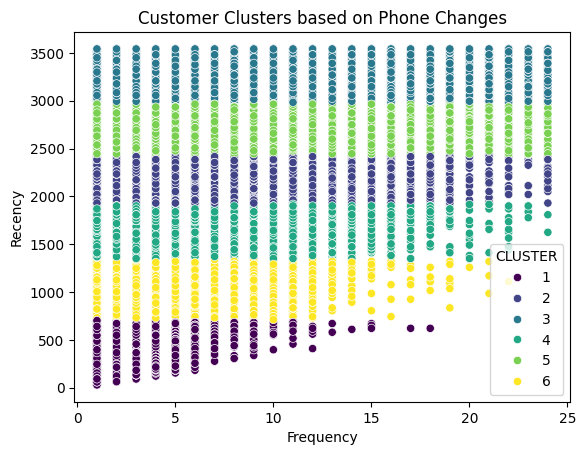

In [48]:
features = merged_df[['frequency', 'recency']]

kmeans = KMeans(n_clusters=6, random_state=42)
merged_df['CLUSTER'] = kmeans.fit_predict(features)
merged_df['CLUSTER'] = merged_df['CLUSTER'] + 1

sns.scatterplot(x='frequency', y='recency', hue='CLUSTER', data=merged_df, palette='viridis')
plt.title('Customer Clusters based on Phone Changes')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

## Clustering users

#### Main Chart (in days)

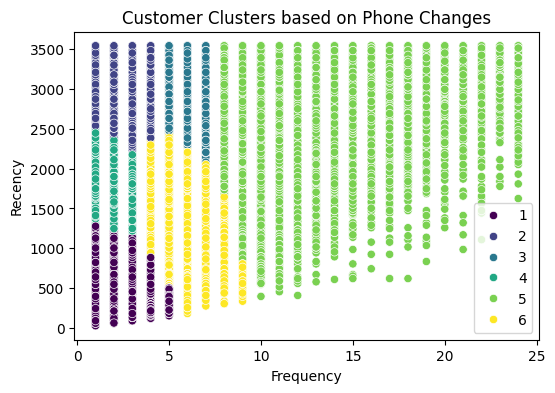

In [49]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[['frequency', 'recency']])
kmeans = KMeans(n_clusters=6, random_state=42)
merged_df['CLUSTER'] = kmeans.fit_predict(scaled_features)
merged_df['CLUSTER'] = merged_df['CLUSTER'] + 1
plt.figure(figsize=(6, 4))  
sns.scatterplot(x='frequency', y='recency', hue='CLUSTER',
                 data=merged_df, palette='viridis')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.title('Customer Clusters based on Phone Changes')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

In [50]:
merged_df.sample(10)

,ID,frequency,recency,T,predicted_purchases,CHANGED_PHONE,threshold,ratio,recency_score,frequency_score,ratio_score,RFM_INT,CLUSTER
1516864,2802188,3,2842,2842.0,0.193814,1,0,947.333333,7,3,3,18,2
394763,728246,3,1808,1808.0,0.252588,0,0,602.666667,6,3,2,17,4
748709,1382936,8,2872,2872.0,0.360160,0,0,359.000000,7,8,1,32,5
38458,70922,4,2569,2569.0,0.242465,0,0,642.250000,7,4,2,21,2
814927,1505718,9,3269,3269.0,0.361600,0,0,363.222222,8,9,1,36,5
2119061,4137107,1,3208,3208.0,0.116691,0,0,3208.000000,8,1,7,14,2
722344,1334056,1,2051,2051.0,0.153653,0,0,2051.000000,6,1,5,12,4
1759966,3264449,3,1961,1961.0,0.241740,0,0,653.666667,6,3,2,17,4
629221,1162088,3,2660,2660.0,0.202091,0,0,886.666667,7,3,3,18,2
1758275,3260746,2,2416,2416.0,0.177029,0,0,1208.000000,7,2,4,15,2


#### Pairplot for clustering users 

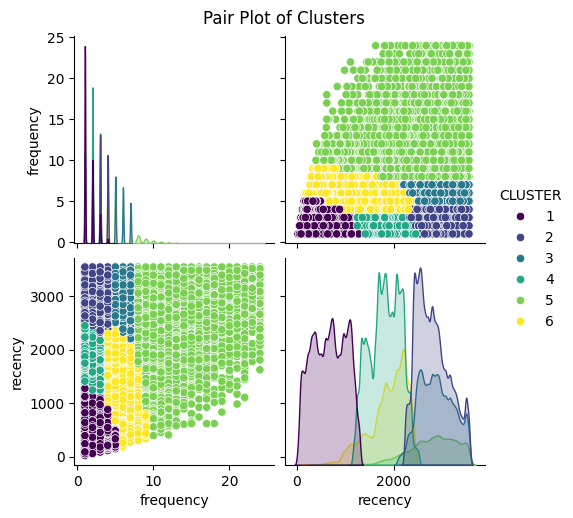

In [51]:
sns.pairplot(merged_df, hue='CLUSTER', palette='viridis', vars=['frequency', 'recency'])
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

### Main chart 2  (in days)

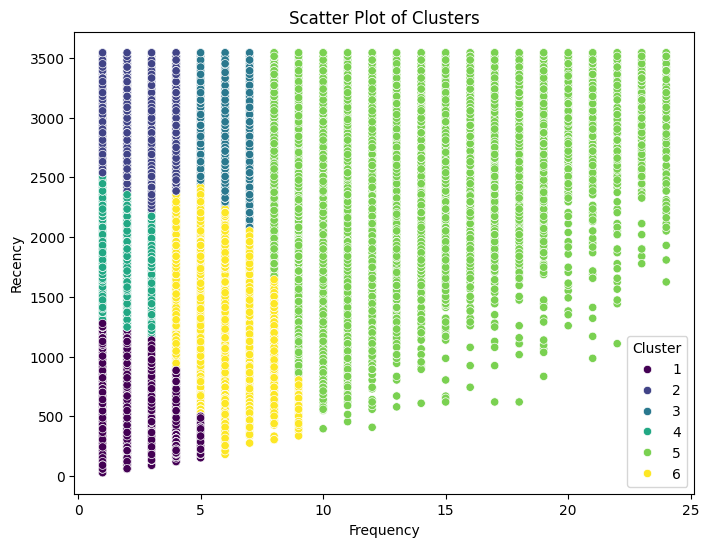

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='frequency', y='recency', hue='CLUSTER', data=merged_df, palette='viridis')

plt.title('Scatter Plot of Clusters')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.legend(title='Cluster')
plt.show()

### WCSS & Identiftying the elbow point

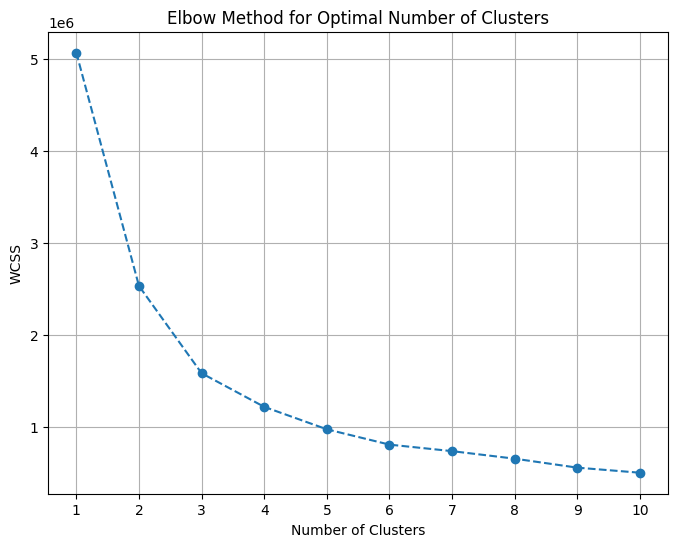

In [53]:
cluster_range = range(1, 11)  
wcss = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)  
    wcss.append(kmeans.inertia_)  

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

### Clustering users (in weeks)

C:\Users\liana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


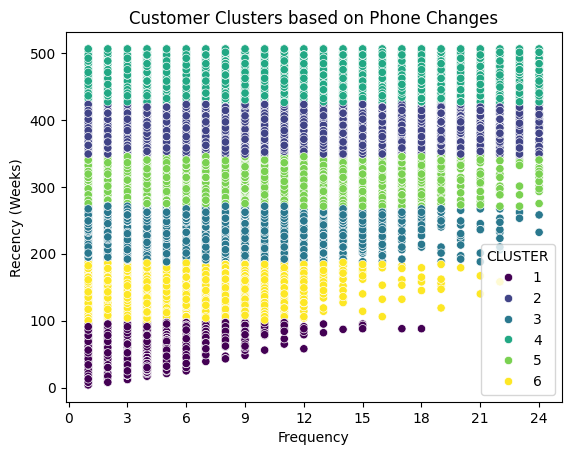

In [54]:
features = clustering_weeks[['frequency', 'recency']]

kmeans = KMeans(n_clusters=6, random_state=42)
clustering_weeks['CLUSTER'] = kmeans.fit_predict(features)
clustering_weeks['CLUSTER'] = clustering_weeks['CLUSTER'] + 1

sns.scatterplot(x='frequency', y='recency', hue='CLUSTER', data=clustering_weeks, palette='viridis')
plt.title('Customer Clusters based on Phone Changes')
plt.xlabel('Frequency')
plt.ylabel('Recency (Weeks)')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()

##### Pairplot for clustering users

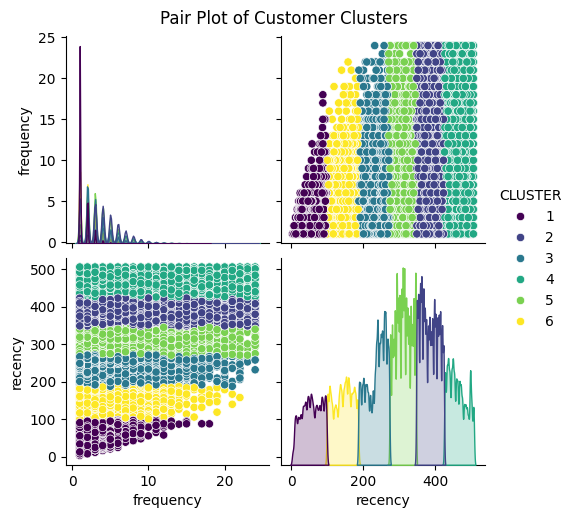

In [55]:
features = ['frequency', 'recency']  

sns.pairplot(clustering_weeks, hue='CLUSTER', palette='viridis', vars=features)
plt.suptitle('Pair Plot of Customer Clusters', y=1.02)
plt.show()

### Clustering users (in months)

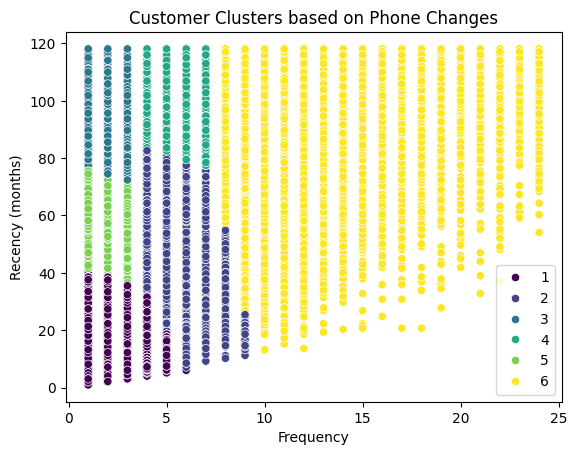

In [56]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_months[['frequency', 'recency']])

kmeans = KMeans(n_clusters=6, random_state=42)
clustering_months['CLUSTER'] = kmeans.fit_predict(scaled_features)
clustering_months['CLUSTER'] = clustering_months['CLUSTER'] + 1
sns.scatterplot(x='frequency', y='recency', hue='CLUSTER', data=clustering_months, palette='viridis')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.title('Customer Clusters based on Phone Changes')
plt.xlabel('Frequency')
plt.ylabel('Recency (months)')
plt.show()